In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
from fastai import *        # Quick accesss to most common functionality
from fastai.text import *   # Quick accesss to NLP functionality
import html

## Data

## Loading data

In [3]:
PATH=Path('data/wikitext-2')

In [4]:
bs = 64
bptt = 70

In [5]:
data = TextLMDataBunch.load(PATH, bs=bs, bptt=bptt)

In [6]:
from fastai.callbacks import RNNTrainer
def rnn_patch_on_loss_begin(self, last_output:Tuple[Tensor,Tensor,Tensor], **kwargs):
    "Save the extra outputs for later and only returns the true output."
    self.raw_out,self.out = last_output[1],last_output[2]
    return last_output[0], self.out


RNNTrainer.on_loss_begin = rnn_patch_on_loss_begin


# Need to find shortcut for monkey patching on individual instances - https://filippo.io/instance-monkey-patching-in-python/
# or just subclass
# learn.callbacks[0].on_loss_begin = rnn_patch_on_loss_begin

In [7]:
learn = language_model_learner(data, clip=0.2)

In [8]:
data.loss_func

In [9]:
class CosSoftmaxLoss(nn.Module):
    def __init__(self, emb_layer, base_loss):
        super().__init__()
        self.base_loss = base_loss
        self.emb_layer = emb_layer
        
    def forward(self, input, target):
        decoded, outputs = input
        with torch.no_grad():
            target_emb = self.emb_layer(target)
        base_l = self.base_loss(decoded, target)
        cos_l = (1 - torch.nn.functional.cosine_similarity(target_emb, outputs[-1].detach(), dim=2).mean())
        return base_l/5 + cos_l*8
        

In [10]:
r_emb = learn.model[0].encoder

In [11]:
learn.loss_func = CosSoftmaxLoss(r_emb, learn.loss_func)

In [12]:
# learn.opt_fn = partial(optim.Adam, betas=(0.8,0.99))
# learn.callback_fns.extend([partial(GradientClipping, clip=0.12)])

In [13]:
epoch = 6
lr = 1e-3
momentum = (0.8,0.7)
weight_decay = 1.2e-6

In [14]:
learn.metrics = [lambda input, targs: accuracy(input[0], targs)]

In [15]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [16]:
learn.fit_one_cycle(epoch, lr, moms=momentum, wd=weight_decay)

epoch,train_loss,valid_loss,
1,1.890436,1.779964,0.773311


KeyboardInterrupt: 

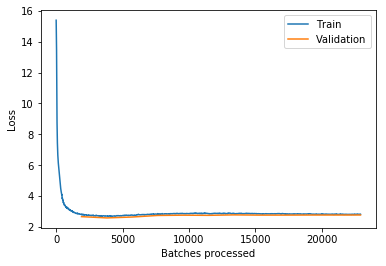

In [15]:
learn.recorder.plot_losses()

In [16]:
learn.save('lstm_wt2_newloss')

### Testing (for fun)

In [18]:
learn.load('lstm_wt2_newloss'); learn.model.eval();

In [19]:
x_str = "The online encyclopedia project Wikipedia is the most popular wiki-based website, and is"

In [20]:
pred_out = learn.predict(x_str, n_words=500)

RuntimeError: invalid argument 2: invalid multinomial distribution (sum of probabilities <= 0) at /home/ubuntu/pytorch/aten/src/TH/generic/THTensorRandom.cpp:316

In [ ]:
pred_out